# <center> svm-gpu sample code </center>

# Code evaluating performance of svm-gpu vs sklearn

In [5]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing

def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        
        print('func:%r args:%r took: %2.4f sec' % (f.__name__, kw, te-ts))
        return result

    return timed

@timeit
def train_and_compute_misclassification(kernel, kernel_params, classification_strategy, x_train, y_train, x_test, y_test, lambduh=1, use_optimal_lambda=False, n_folds=3, max_iter=200):   
    print('svm-gpu, {} kernel, parameters {}'.format(kernel, kernel_params))
    svm = SVM(kernel, kernel_params, lambduh, max_iter, classification_strategy, x=x_train, y=y_train, n_folds=n_folds, display_plots=True)

    svm.fit(x_train, y_train, use_optimal_lambda=use_optimal_lambda)
    if svm._classification_strategy == 'binary':
        svm.plot_misclassification_error()

    misclassification_error = svm.compute_misclassification_error(x_test, y_test)
    print('Misclassification error (test), {}, {}lambda = {} : {}\n'.format(svm._classification_strategy, ('optimal ' if use_optimal_lambda else ''), svm._lambduh, misclassification_error))

@timeit
def train_and_compute_misclassification_sklearn(kernel, x_train, y_train, x_test, y_test, lambduh=1, use_optimal_lambda=False, n_folds=3, max_iter=200, decision_function_shape='ovr'):
    x_train = xp.asnumpy(x_train)
    y_train = xp.asnumpy(y_train)
    x_test = xp.asnumpy(x_test)
    y_test = xp.asnumpy(y_test)
    
    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    print('sklearn, {} kernal'.format(kernel))    
    svm = SVC(kernel=kernel, C=lambduh, decision_function_shape=decision_function_shape, max_iter=max_iter)
    
    if (use_optimal_lambda is True):
        params = {'C':[10**i for i in range(-3, 4)] }
        svm = GridSearchCV(svm, params, cv=n_folds)
        
    svm.fit(x_train, y_train)
    
    if (use_optimal_lambda is True):
        lambduh = svm.best_params_['C']
    
    misclassification_error = 1 - svm.score(x_test, y_test)
    print("Misclassification error (test), {}, {}lambda = {} : {}\n".format(decision_function_shape, ('optimal ' if use_optimal_lambda else ''), lambduh, misclassification_error))

# Prepare simulated dataset

In [2]:
import cupy as xp 
import sklearn.model_selection
import time
from svm import SVM
import kernels

xp.random.seed(0)
x_simulated = xp.concatenate((xp.random.normal(-10,10,(100,60)),
                              xp.random.normal(0,10,(100,60)),
                              xp.random.normal(10,10,(100,60)),
                              xp.random.uniform(-1,1,(100,60))),axis=0)

y_simulated = xp.concatenate((xp.tile(0, 100),
                              xp.tile(1, 100),
                              xp.tile(2, 100),
                              xp.tile(3, 100)),axis=0)

# Divide the data into train, test sets 
x_train_simulated, x_test_simulated, y_train_simulated, y_test_simulated = sklearn.model_selection.train_test_split(x_simulated, y_simulated)


# Binary performance with simulated dataset, linear kernel, optimal lambda

In [3]:
# Get a binary subset of the data
x_train_binary_simulated, y_train_binary_simulated = SVM.filter_data_by_class_ovo(x_train_simulated, y_train_simulated, [0,1], True)
x_test_binary_simulated, y_test_binary_simulated = SVM.filter_data_by_class_ovo(x_test_simulated, y_test_simulated, [0,1], True)

svm-gpu, linear kernel, parameters {}


,lambda,Cross validation error
0,0.001,0.0
1,0.010,0.0
2,0.100,0.0
3,1.000,0.0
4,10.000,0.0
5,100.000,0.0
6,1000.000,0.0


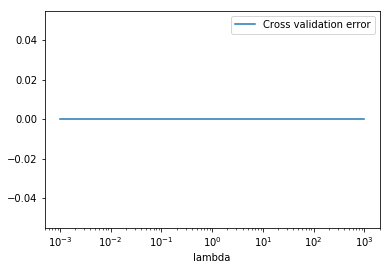

Misclassification error (train), binary, optimal lambda = 0.001 : 0.0


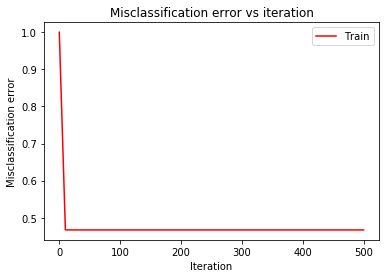

Misclassification error (test), binary, optimal lambda = 0.001 : 0.0

func:'train_and_compute_misclassification' args:{'use_optimal_lambda': True} took: 42.4410 sec


In [4]:
train_and_compute_misclassification('linear', {}, 'binary', x_train_binary_simulated, y_train_binary_simulated, x_test_binary_simulated, y_test_binary_simulated, use_optimal_lambda=True)


In [46]:
train_and_compute_misclassification_sklearn('linear', x_train_binary_simulated, y_train_binary_simulated, x_test_binary_simulated, y_test_binary_simulated, use_optimal_lambda=True)


sklearn, linear kernal
Misclassification error (test), ovr, optimal lambda = 0.001 : 0.0

func:'train_and_compute_misclassification_sklearn' args:{'use_optimal_lambda': True} took: 0.9327 sec


# Multi-class performance with simulated dataset, rbf kernel, optimal lambda


svm-gpu, rbf kernel, parameters {'sigma': 7}


,lambda,Cross validation error
0,0.001,0.280963
1,0.010,0.329405
2,0.100,0.399698
3,1.000,0.446524
4,10.000,0.464916
5,100.000,0.459858
6,1000.000,0.453216


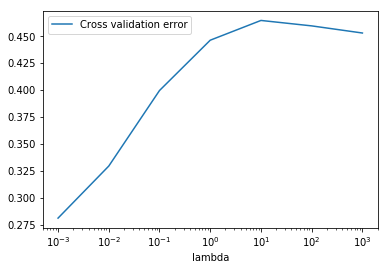

Misclassification error (train), ovr, optimal lambda = 0.001 : 0.28096314907872694


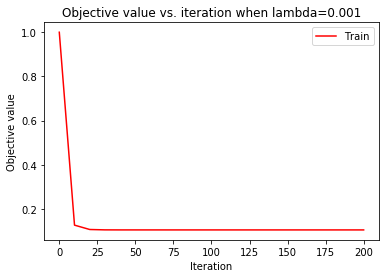

Misclassification error (test), ovr, optimal lambda = 0.001 : 0.19

func:'train_and_compute_misclassification' args:{'use_optimal_lambda': True} took: 88.3852 sec


In [14]:
train_and_compute_misclassification('rbf', {'sigma': 7}, 'ovr', x_train_simulated, y_train_simulated, x_test_simulated, y_test_simulated, use_optimal_lambda=True)

In [10]:
train_and_compute_misclassification_sklearn('rbf', x_train_simulated, y_train_simulated, x_test_simulated, y_test_simulated, use_optimal_lambda=True)

sklearn, rbf kernal
Misclassification error (test), ovr, optimal lambda = 0.1 : 0.0

func:'train_and_compute_misclassification_sklearn' args:{'use_optimal_lambda': True} took: 0.4853 sec


# Prepare read world dataset (sklearn digits)

In [15]:
from sklearn.datasets import load_digits

digits = load_digits()

# Divide the data into train, test sets 
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(digits.data, digits.target)

# Move data to GPU
x_train = xp.asarray(x_train)
x_test =  xp.asarray(x_test)
y_train = xp.asarray(y_train)
y_test = xp.asarray(y_test)

# Binary performance with real world dataset, linear kernel, optimal lambda

In [59]:
# Get a binary subset of the data
x_train_binary, y_train_binary = SVM.filter_data_by_class_ovo(x_train, y_train, [0,1], True)
x_test_binary, y_test_binary = SVM.filter_data_by_class_ovo(x_test, y_test, [0,1], True)

svm-gpu, linear kernel, parameters {}


,lambda,Cross validation error
0,0.001,0.0
1,0.010,0.0
2,0.100,0.0
3,1.000,0.0
4,10.000,0.0
5,100.000,0.0
6,1000.000,0.0


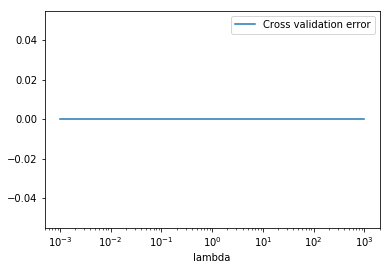

Misclassification error (train), binary, optimal lambda = 0.001 : 0.0


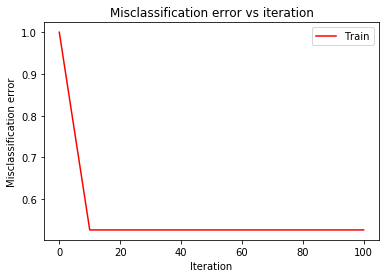

Misclassification error (test), binary, optimal lambda = 0.001 : 0.0

func:'train_and_compute_misclassification' args:{'use_optimal_lambda': True} took: 15.8370 sec


In [70]:
train_and_compute_misclassification('linear', {}, 'binary', x_train_binary_simulated, y_train_binary_simulated, x_test_binary_simulated, y_test_binary_simulated, use_optimal_lambda=True)


In [71]:
train_and_compute_misclassification_sklearn('linear', x_train_binary_simulated, y_train_binary_simulated, x_test_binary_simulated, y_test_binary_simulated, use_optimal_lambda=True)

sklearn, linear kernal
Misclassification error (test), ovr, optimal lambda = 0.001 : 0.0

func:'train_and_compute_misclassification_sklearn' args:{'use_optimal_lambda': True} took: 0.1360 sec


# Multi-class performance with real world dataset, rbf kernel, optimal lambda

svm-gpu, rbf kernel, parameters {'sigma': 15}


,lambda,Cross validation error
0,0.001,0.266707
1,0.010,0.282318
2,0.100,0.226965
3,1.000,0.220651
4,10.000,0.225124
5,100.000,0.229580
6,1000.000,0.267488


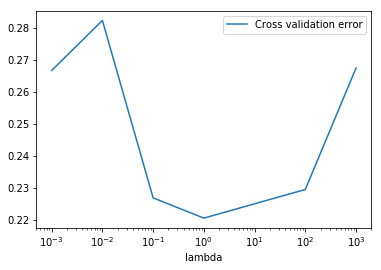

Misclassification error (train), ovr, optimal lambda = 1 : 0.22065136696685064


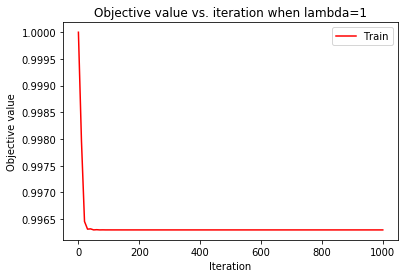

Misclassification error (test), ovr, optimal lambda = 1 : 0.17777777777777778

func:'train_and_compute_misclassification' args:{'use_optimal_lambda': True} took: 1089.8553 sec


In [4]:
train_and_compute_misclassification('rbf', {'sigma': 15}, 'ovr', x_train, y_train, x_test, y_test, use_optimal_lambda=True)

In [9]:
train_and_compute_misclassification_sklearn('rbf', x_train, y_train, x_test, y_test, use_optimal_lambda=True)

sklearn, rbf kernal
Misclassification error (test), ovr, optimal lambda = 10 : 0.015555555555555545

func:'train_and_compute_misclassification_sklearn' args:{'use_optimal_lambda': True} took: 4.4520 sec


In [18]:
train_and_compute_misclassification_sklearn('linear', x_train, y_train, x_test, y_test, use_optimal_lambda=True)

sklearn, linear kernal
Misclassification error (test), ovr, optimal lambda = 0.1 : 0.01777777777777778

func:'train_and_compute_misclassification_sklearn' args:{'use_optimal_lambda': True} took: 2.6927 sec


svm-gpu, linear kernel, parameters {}


,lambda,Cross validation error
0,0.001,0.306488
1,0.010,0.229196
2,0.100,0.217332
3,1.000,0.159352
4,10.000,0.124446
5,100.000,0.145989
6,1000.000,0.151194


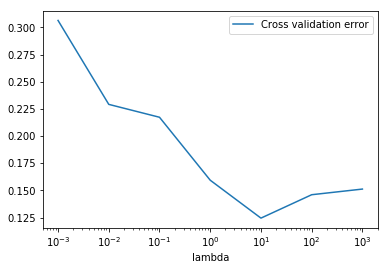

Misclassification error (train), ovr, optimal lambda = 10 : 0.12444558658367122


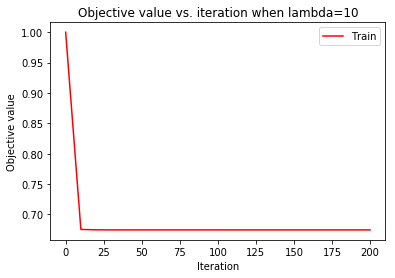

Misclassification error (test), ovr, optimal lambda = 10 : 0.1688888888888889

func:'train_and_compute_misclassification' args:{'use_optimal_lambda': True} took: 230.1408 sec


In [19]:
train_and_compute_misclassification('linear', {}, 'ovr', x_train, y_train, x_test, y_test, use_optimal_lambda=True)